## Run #2 - PV-BESS

Determin BESS size

In [1]:
# dependencies

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pulp import *


In [2]:

# data inputs
# load time series data
data = pd.read_csv('./all-series.csv')
data = data.drop(data.columns[168:])

data = data.set_index('Hour', drop=True)
irradiance = data['Irradiance (Wh/m2)']          # Wh/m2
sma = data['Consumption Sma (kWh/h)'] * 1.2              # time series with electricity consumption
saft = data['Consumption Saft (kWh/h)'] * 1.05
oe_cons = data['DH plant Consumption (kWh/h)'] * 1.05

cons = sma + saft + oe_cons

hourly_price = data['Day Ahead (EUR/MWh)'] / 1000      # time series with electricity spot price

# network tariff
net_charge = 0.04257    # eur/kWh

# pv parameters
sqm_pv = 30000          # m2
conv_eff = 0.2          # %
price_pv = 120          # eur / sqm

# battery parameters
batt_cap_list = list(range(200, 1001, 100))          # kWh
# batt_pwr = batt_cap_list / 2   # kW
deg_price = 0.011       # eur/kWh
price_batt = 320        # eur / kWh

# co2 data
co2grid = 0.039         # kgco2/kwh 
co2pv = 350             # kgco2/m2
co2bess = 89            # kgco2/kwh
lcpv = 30               # years
lcbess = 20             # years

init_disp = 0 # no of days from march 1st, 2021 initial time step is desired
init = 0 + init_disp * 24
n = 4380

# data for optimization
load = np.array(cons[init:init+n])
PV_gen = np.array(irradiance[init:init+n] * (sqm_pv / 1000) * conv_eff) 
price = np.array(hourly_price[init:init+n])

min_cost_list = []
capex_list = []

for batt_cap in batt_cap_list:

    batt_pwr = batt_cap / 2
    CAPEX = price_pv * sqm_pv + price_batt * batt_cap

    # create prob
    prob = LpProblem('GridPVBatt', LpMinimize)

    # dec vars
    # energy from grid
    E_G = [LpVariable('E_G_{}'.format(i), 0, None) for i in range(n)]
    # energy from PV
    E_PV = [LpVariable('E_PV_{}'.format(i), 0, None) for i in range(n)]
    # energy curtailed
    E_curt = [LpVariable('E_curt_{}'.format(i), 0, None) for i in range(n)]
    # energy charged
    E_ch_pv = [LpVariable('E_ch_pv_{}'.format(i), 0, batt_pwr) for i in range(n)]
    E_ch_grid = [LpVariable('E_ch_grid_{}'.format(i), 0, batt_pwr) for i in range(n)]
    # energy discharged
    E_dis_cons = [LpVariable('E_dis_cons_{}'.format(i), 0, batt_pwr) for i in range(n)]
    E_dis_sold = [LpVariable('E_dis_sold_{}'.format(i), 0, batt_pwr) for i in range(n)]
    prob += E_dis_cons[0] == 0
    prob += E_dis_sold[0] == 0
    batt_status = [LpVariable('batt_status_{}'.format(i), cat='Binary') for i in range(n)]
    M = 1000000     # large positive number that acts as upper bound
    # soc
    SOC = [LpVariable('SOC_{}'.format(i), 0, batt_cap) for i in range(n)]
    prob += SOC[0] == 0

    # obj function: min total elec cost 
    # - assume price = 0 for pv electricity
    # - assume price = deg_price per kWh charge/discharged
    # - assume price of curtailment = spot price (not realistic)
    # - assume price of sold energy from batt = spot price
    prob += lpSum([  E_G[t] *           (price[t] + net_charge)
                + E_PV[t] *          (0)
                + E_curt[t] *        (-price[t] + net_charge) 
                + E_ch_pv[t] *       (deg_price)
                + E_ch_grid[t] *     (deg_price + net_charge + price[t])
                + E_dis_cons[t] *    (deg_price)
                + E_dis_sold[t] *    (deg_price + net_charge - price[t])] 
                for t in range(n))

    # constraints
    for t in range(1, n):
        # soc
        prob += SOC[t] == SOC[t-1] + E_ch_grid[t] + E_ch_pv[t] - E_dis_cons[t] - E_dis_sold[t]

    for t in range(0, n):

        # power balance
        prob += E_G[t] + E_PV[t] + E_dis_cons[t] + E_dis_sold[t] == load[t] + E_ch_grid[t] + E_ch_pv[t] + E_curt[t]

        # pv cons always lower than prod
        prob += E_PV[t] + E_curt[t] + E_ch_pv[t] == PV_gen[t]

        # charge and discharge limits
        prob += E_dis_sold[t] + E_dis_cons[t] + E_ch_pv[t] + E_ch_grid[t] <= batt_pwr
        prob += E_ch_pv[t] + E_ch_grid[t] <= M * batt_status[t]
        prob += E_dis_cons[t] + E_dis_sold[t] <= M * (1 - batt_status[t])

    # solve
    status = prob.solve()
    print(LpStatus[status])

    # print(f'~~~~~~~~~~~~~~~\nInstallation summary')
    # print(f'Installed PV (square meters): {sqm_pv : 0.1f}')
    # print(f'Battery capacity (kWh): {batt_cap : 0.1f}')
    # print(f'Battery power (kW): {batt_pwr : 0.1f}')
    # print(f'CAPEX (EUR): {CAPEX : 0.1f}\n~~~~~~~~~~~~~~~')
    # print(f'Minimum cost of electricity: {pulp.value(prob.objective) : 0.1f}€')
    # print(f'Emissions avoided (kgCO2 eq): {emissions : 0.1f}')

    min_cost_list.append(pulp.value(prob.objective))
    capex_list.append(CAPEX)


Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal


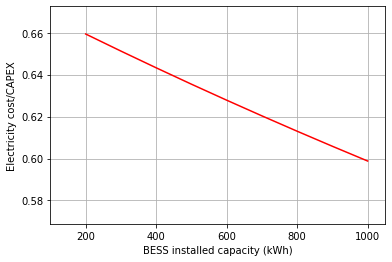

In [3]:
ratio = [min_cost_list[i] * 4 / capex_list[i] for i in range(len(min_cost_list))]

plt.plot(batt_cap_list, ratio, 'r')
plt.axis([100,max(batt_cap_list)*1.05,min(ratio)*0.95,max(ratio)*1.02])
plt.rcParams['figure.figsize'] = (8,5)
plt.xlabel('BESS installed capacity (kWh)')
plt.ylabel('Electricity cost/CAPEX')
plt.grid(True)
plt.show()

In [4]:
# data inputs
# load time series data
data = pd.read_csv('./all-series.csv')
data = data.drop(data.columns[168:])

data = data.set_index('Hour', drop=True)
irradiance = data['Irradiance (Wh/m2)']          # Wh/m2
sma = data['Consumption Sma (kWh/h)'] * 1.2              # time series with electricity consumption
saft = data['Consumption Saft (kWh/h)'] * 1.05
oe_cons = data['DH plant Consumption (kWh/h)'] * 1.05

cons = sma + saft + oe_cons

hourly_price = data['Day Ahead (EUR/MWh)'] / 1000      # time series with electricity spot price

# network tariff
net_charge = 0.04257    # eur/kWh

# pv parameters
sqm_pv = 30000          # m2
conv_eff = 0.2          # %
price_pv = 120          # eur / sqm

# battery parameters
batt_cap = 1000          # kWh
batt_pwr = 500          # kW
deg_price = 0.011       # eur/kWh
price_batt = 320        # eur / kWh

# co2 data
co2grid = 0.039         # kgco2/kwh 
co2pv = 350             # kgco2/m2
co2bess = 89            # kgco2/kwh
lcpv = 30               # years
lcbess = 20             # years

CAPEX = price_pv * sqm_pv + price_batt * batt_cap

# displacements to be run:
#   - Mar 21st, 2022 - init_disp = 385
#   - Jun 20th, 2022 - init_disp = 476
#   - Sep 19th, 2022 - init_disp = 567
#   - Dec 19th, 2022 - init_disp = 658
init_disp = 0 # no of days from march 1st, 2021 initial time step is desired

init = 0 + init_disp * 24
n = 8760

# data for optimization
load = np.array(cons[init:init+n])
PV_gen = np.array(irradiance[init:init+n] * (sqm_pv / 1000) * conv_eff) 
price = np.array(hourly_price[init:init+n])

# create prob
prob = LpProblem('GridPVBatt', LpMinimize)

# dec vars
# energy from grid
E_G = [LpVariable('E_G_{}'.format(i), 0, None) for i in range(n)]
# energy from PV
E_PV = [LpVariable('E_PV_{}'.format(i), 0, None) for i in range(n)]
# energy curtailed
E_curt = [LpVariable('E_curt_{}'.format(i), 0, None) for i in range(n)]
# energy charged
E_ch_pv = [LpVariable('E_ch_pv_{}'.format(i), 0, batt_pwr) for i in range(n)]
E_ch_grid = [LpVariable('E_ch_grid_{}'.format(i), 0, batt_pwr) for i in range(n)]
# energy discharged
E_dis_cons = [LpVariable('E_dis_cons_{}'.format(i), 0, batt_pwr) for i in range(n)]
E_dis_sold = [LpVariable('E_dis_sold_{}'.format(i), 0, batt_pwr) for i in range(n)]
prob += E_dis_cons[0] == 0
prob += E_dis_sold[0] == 0
batt_status = [LpVariable('batt_status_{}'.format(i), cat='Binary') for i in range(n)]
M = 1000000     # large positive number that acts as upper bound
# soc
SOC = [LpVariable('SOC_{}'.format(i), 0, batt_cap) for i in range(n)]
prob += SOC[0] == 0

# obj function: min total elec cost 
# - assume price = 0 for pv electricity
# - assume price = deg_price per kWh charge/discharged
# - assume price of curtailment = spot price (not realistic)
# - assume price of sold energy from batt = spot price
prob += lpSum([  E_G[t] *           (price[t] + net_charge)
               + E_PV[t] *          (0)
               + E_curt[t] *        (-price[t] + net_charge) 
               + E_ch_pv[t] *       (deg_price)
               + E_ch_grid[t] *     (deg_price + net_charge + price[t])
               + E_dis_cons[t] *    (deg_price)
               + E_dis_sold[t] *    (deg_price + net_charge - price[t])] 
               for t in range(n))

# constraints
for t in range(1, n):
    # soc
    prob += SOC[t] == SOC[t-1] + E_ch_grid[t] + E_ch_pv[t] - E_dis_cons[t] - E_dis_sold[t]

for t in range(0, n):

    # power balance
    prob += E_G[t] + E_PV[t] + E_dis_cons[t] + E_dis_sold[t] == load[t] + E_ch_grid[t] + E_ch_pv[t] + E_curt[t]

    # pv cons always lower than prod
    prob += E_PV[t] + E_curt[t] + E_ch_pv[t] == PV_gen[t]

    # charge and discharge limits
    prob += E_dis_sold[t] + E_dis_cons[t] + E_ch_pv[t] + E_ch_grid[t] <= batt_pwr
    prob += E_ch_pv[t] + E_ch_grid[t] <= M * batt_status[t]
    prob += E_dis_cons[t] + E_dis_sold[t] <= M * (1 - batt_status[t])

# solve
status = prob.solve()
print(LpStatus[status])

# make records to prep df
res = []
for t in range(n):
    record = {  'Hour': t,
                'Load': load[t],
                'PV production': PV_gen[t],
                'Spot price': price[t],
                'Energy from grid': E_G[t].varValue,
                'Energy from PV': E_PV[t].varValue,
                'Energy curtailed': E_curt[t].varValue,
                'Energy charged from PV': E_ch_pv[t].varValue,
                'Energy charged from grid': E_ch_grid[t].varValue,
                'Energy consumed from battery': E_dis_cons[t].varValue,
                'Energy sold from battery': E_dis_sold[t].varValue,
                'SOC': SOC[t].varValue
    }
    res.append(record)

df = pd.DataFrame.from_records(res)
df.set_index('Hour', inplace=True)
df = df.round(2)
# print(df.to_string())
df.to_csv('00-results.csv', encoding='utf-8')

emissions = ((sum(df['Energy from PV'])*2 + sum(df['Energy consumed from battery'])*2) 
             * co2grid - sqm_pv * (2*co2pv/lcpv) - batt_cap * (2*co2bess/lcbess))

print(f'~~~~~~~~~~~~~~~\nInstallation summary')
print(f'Installed PV (square meters): {sqm_pv : 0.1f}')
print(f'Battery capacity (kWh): {batt_cap : 0.1f}')
print(f'Battery power (kW): {batt_pwr : 0.1f}')
print(f'CAPEX (EUR): {CAPEX : 0.1f}\n~~~~~~~~~~~~~~~')
print(f'Minimum cost of electricity: {pulp.value(prob.objective)*2 : 0.1f}€')
print(f'Emissions avoided (kgCO2 eq): {emissions : 0.1f}')

# df.plot(figsize=[15,5])
# plt.show()

Optimal
~~~~~~~~~~~~~~~
Installation summary
Installed PV (square meters):  30000.0
Battery capacity (kWh):  1000.0
Battery power (kW):  500.0
CAPEX (EUR):  3920000.0
~~~~~~~~~~~~~~~
Minimum cost of electricity:  5099975.4€
Emissions avoided (kgCO2 eq): -92867.9


Optimal


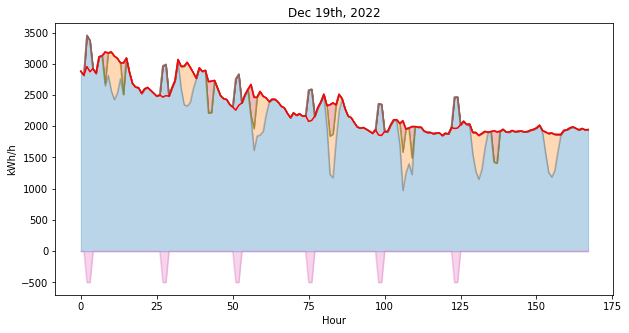

In [32]:
# data inputs
# load time series data
data = pd.read_csv('./all-series.csv')
data = data.drop(data.columns[168:])

data = data.set_index('Hour', drop=True)
irradiance = data['Irradiance (Wh/m2)']          # Wh/m2
sma = data['Consumption Sma (kWh/h)'] * 1.2              # time series with electricity consumption
saft = data['Consumption Saft (kWh/h)'] * 1.05
oe_cons = data['DH plant Consumption (kWh/h)'] * 1.05

cons = sma + saft + oe_cons

hourly_price = data['Day Ahead (EUR/MWh)'] / 1000      # time series with electricity spot price

# network tariff
net_charge = 0.04257    # eur/kWh

# pv parameters
sqm_pv = 30000          # m2
conv_eff = 0.2          # %
price_pv = 120          # eur / sqm

# battery parameters
batt_cap = 1000          # kWh
batt_pwr = 500          # kW
deg_price = 0.011       # eur/kWh
price_batt = 320        # eur / kWh

# co2 data
co2grid = 0.039         # kgco2/kwh 
co2pv = 350             # kgco2/m2
co2bess = 89            # kgco2/kwh
lcpv = 30               # years
lcbess = 20             # years

CAPEX = price_pv * sqm_pv + price_batt * batt_cap

# displacements to be run:
#   - Mar 21st, 2022 - init_disp = 385
#   - Jun 20th, 2022 - init_disp = 476
#   - Sep 19th, 2022 - init_disp = 567
#   - Dec 19th, 2022 - init_disp = 658
init_disp = 658 # no of days from march 1st, 2021 initial time step is desired

init = 0 + init_disp * 24
n = 168

# data for optimization
load = np.array(cons[init:init+n])
PV_gen = np.array(irradiance[init:init+n] * (sqm_pv / 1000) * conv_eff) 
price = np.array(hourly_price[init:init+n])

# create prob
prob = LpProblem('GridPVBatt', LpMinimize)

# dec vars
# energy from grid
E_G = [LpVariable('E_G_{}'.format(i), 0, None) for i in range(n)]
# energy from PV
E_PV = [LpVariable('E_PV_{}'.format(i), 0, None) for i in range(n)]
# energy curtailed
E_curt = [LpVariable('E_curt_{}'.format(i), 0, None) for i in range(n)]
# energy charged
E_ch_pv = [LpVariable('E_ch_pv_{}'.format(i), 0, batt_pwr) for i in range(n)]
E_ch_grid = [LpVariable('E_ch_grid_{}'.format(i), 0, batt_pwr) for i in range(n)]
# energy discharged
E_dis_cons = [LpVariable('E_dis_cons_{}'.format(i), 0, batt_pwr) for i in range(n)]
E_dis_sold = [LpVariable('E_dis_sold_{}'.format(i), 0, batt_pwr) for i in range(n)]
prob += E_dis_cons[0] == 0
prob += E_dis_sold[0] == 0
batt_status = [LpVariable('batt_status_{}'.format(i), cat='Binary') for i in range(n)]
M = 1000000     # large positive number that acts as upper bound
# soc
SOC = [LpVariable('SOC_{}'.format(i), 0, batt_cap) for i in range(n)]
prob += SOC[0] == 0

# obj function: min total elec cost 
# - assume price = 0 for pv electricity
# - assume price = deg_price per kWh charge/discharged
# - assume price of curtailment = spot price (not realistic)
# - assume price of sold energy from batt = spot price
prob += lpSum([  E_G[t] *           (price[t] + net_charge)
               + E_PV[t] *          (0)
               + E_curt[t] *        (-price[t] + net_charge) 
               + E_ch_pv[t] *       (deg_price)
               + E_ch_grid[t] *     (deg_price + net_charge + price[t])
               + E_dis_cons[t] *    (deg_price)
               + E_dis_sold[t] *    (deg_price + net_charge - price[t])] 
               for t in range(n))

# constraints
for t in range(1, n):
    # soc
    prob += SOC[t] == SOC[t-1] + E_ch_grid[t] + E_ch_pv[t] - E_dis_cons[t] - E_dis_sold[t]

for t in range(0, n):

    # power balance
    prob += E_G[t] + E_PV[t] + E_dis_cons[t] + E_dis_sold[t] == load[t] + E_ch_grid[t] + E_ch_pv[t] + E_curt[t]

    # pv cons always lower than prod
    prob += E_PV[t] + E_curt[t] + E_ch_pv[t] == PV_gen[t]

    # charge and discharge limits
    prob += E_dis_sold[t] + E_dis_cons[t] + E_ch_pv[t] + E_ch_grid[t] <= batt_pwr
    prob += E_ch_pv[t] + E_ch_grid[t] <= M * batt_status[t]
    prob += E_dis_cons[t] + E_dis_sold[t] <= M * (1 - batt_status[t])

# solve
status = prob.solve()
print(LpStatus[status])
# energy balance area plot for one week

areas = []
for t in range(n):
    record = {  'Hour': t,
                'Demand': load[t],
                'Grid cons': E_G[t].varValue,
                'PV cons': E_PV[t].varValue,
                'Battery cons': E_dis_cons[t].varValue,
                'Curtailment': -E_curt[t].varValue,
                'Charge PV': -E_ch_pv[t].varValue,
                'Charge grid': -E_ch_grid[t].varValue,
                'Battery sales': E_dis_sold[t].varValue,
    }
    areas.append(record)

df = pd.DataFrame.from_records(areas)
df.set_index('Hour', inplace=True)
df = df.round(2)

if init_disp == 385:
    plot_title = 'Mar 21st, 2022'
elif init_disp == 476:
    plot_title = 'Jun 20th, 2022'
elif init_disp == 567:
    plot_title = 'Sep 19th, 2022'
elif init_disp == 658:
    plot_title = 'Dec 19th, 2022'
else:
    plot_title = 'Energy balance'

ax = df.plot.area(y=['Grid cons', 'PV cons', 'Battery cons', 'Battery sales',
                     'Curtailment', 'Charge PV', 'Charge grid'], 
                  figsize = (10, 5), stacked=True, alpha=0.3, legend=None)

df.plot(y='Demand', ax=ax, color='red', linestyle='-', legend=None)

plt.title(plot_title)
plt.ylabel('kWh/h')
# plt.legend(bbox_to_anchor=(1, 0.5))

plt.show()
